# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split across nodes
- biband: As for uniband but communication initiated in both directions
- alltoall: As many processes on each node as there are (hardware) cores

Tests use a range of message sizes and report bandwidth and/or latency.

In [11]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for selected tests:
- pingpong
- 2x process runs of uniband and biband
- alltoall (using all cores on each node)

Results are for the most-recent test on each system/partition/environment combination.

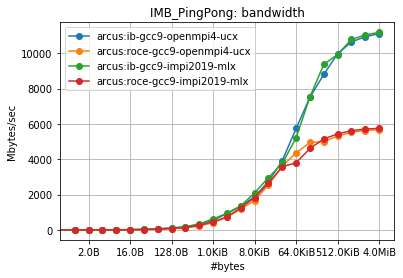

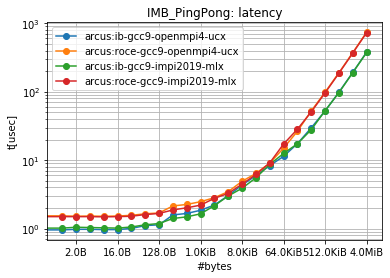

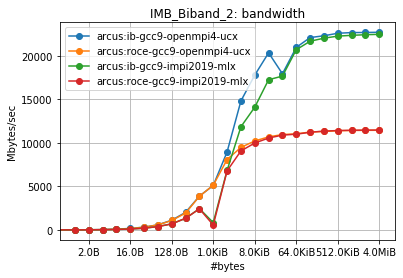

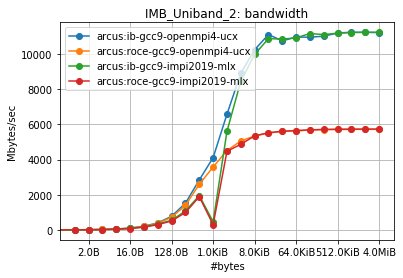

In [13]:
for (test, column, param) in [('IMB_PingPong', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_PingPong', 't[usec]', 'latency'),
                              ('IMB_Biband_2', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_Uniband_2', 'Mbytes/sec', 'bandwidth'),
                             ]:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    
    # load and plot:
    for ix, path in enumerate(paths):
        datas = modules.imb.read_imb_out(path)
        assert len(datas) == 1
        data = datas[list(datas.keys())[0]]
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        plt.plot(data['#bytes'], data[column], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    if param == 'latency':
        ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel(column)
    ax.set_title('%s: %s' % (test, param))
    ax.legend()

# Max Bandwidth vs Number of Processes per Node

The plots below show the **maximum** bandwidth for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

IMB_Uniband_*: Max bandwidth (MB)


case,arcus:ib-gcc9-impi2019-mlx,arcus:ib-gcc9-openmpi4-ucx,arcus:roce-gcc9-impi2019-mlx,arcus:roce-gcc9-openmpi4-ucx
procs_per_node,,,,
1,11245.43,11245.51,5736.58,5722.27
2,12441.28,12232.36,5737.55,5722.97
4,12972.87,12243.86,5737.52,5714.12
8,12976.96,12253.81,5737.59,5718.38
16,13237.33,12259.58,5737.61,5724.10
32,13006.38,12157.74,5719.64,5717.08


IMB_Uniband_*: Max bandwidth as % of theoretical bandwidth


case,arcus:ib-gcc9-impi2019-mlx,arcus:ib-gcc9-openmpi4-ucx,arcus:roce-gcc9-impi2019-mlx,arcus:roce-gcc9-openmpi4-ucx
procs_per_node,,,,
1,89,89,91,91
2,99,97,91,91
4,103,97,91,91
8,103,98,91,91
16,105,98,91,91
32,104,97,91,91


-----------------------------------------------
IMB_Biband_*: Max bandwidth (MB)


case,arcus:ib-gcc9-impi2019-mlx,arcus:ib-gcc9-openmpi4-ucx,arcus:roce-gcc9-impi2019-mlx,arcus:roce-gcc9-openmpi4-ucx
procs_per_node,,,,
1,22457.77,22696.74,11467.97,11439.64
2,22933.10,22892.08,11472.10,11444.38
4,24799.07,24147.77,11473.81,11440.85
8,25131.39,24144.15,11473.98,11427.75
16,25215.31,24198.26,11474.13,11447.02
32,24791.92,24113.19,11390.20,11359.05


IMB_Biband_*: Max bandwidth as % of theoretical bandwidth


case,arcus:ib-gcc9-impi2019-mlx,arcus:ib-gcc9-openmpi4-ucx,arcus:roce-gcc9-impi2019-mlx,arcus:roce-gcc9-openmpi4-ucx
procs_per_node,,,,
1,89,90,91,91
2,91,91,91,91
4,99,96,91,91
8,100,96,91,91
16,100,96,91,91
32,99,96,91,90


-----------------------------------------------


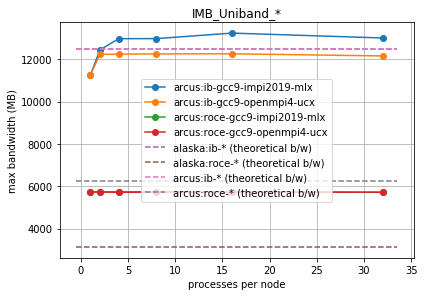

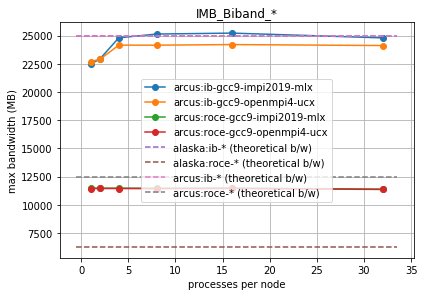

In [14]:
# constants:
Gb_to_MB = 125.0
TEST_BANDWIDTH_FACTOR = {'IMB_Uniband_*':1.0, 'IMB_Biband_*':2.0} # b/c biband is bidirectional

for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    # get, plot and tabulate data:
    df = modules.utils.tabulate_last_perf(test, 'procs_per_node', 'max_bandwidth')
    print('%s: Max bandwidth (MB)' % test)
    display(HTML(df.to_html()))
    ax = df.plot(grid=True, style='o-')
    
    # add max bandwidth info to plot:
    xlim = ax.get_xlim()
    for syspart, bw in modules.utils.get_sys_param('interconnect_Gb').items():
        theoretical_bw_MB = bw * Gb_to_MB * TEST_BANDWIDTH_FACTOR[test]
        label = syspart + " (theoretical b/w)"
        ax.plot(xlim, [theoretical_bw_MB, theoretical_bw_MB], '--', label=label)
    
    # format plot:
    ax.set_xlabel('processes per node')
    ax.set_ylabel('max bandwidth (MB)')
    plt.tight_layout()
    ax.set_title(test)
    ax.legend()
    
    # TODO: calculate real vs theortical perf
    print('%s: Max bandwidth as %% of theoretical bandwidth' % test)
    theory = [modules.utils.get_sysinfo(syspart)['interconnect_Gb'] * Gb_to_MB * TEST_BANDWIDTH_FACTOR[test] for syspart in df.columns]
    df_percent = 100 * (df / theory)
    #print('theory:', theory)
    display(HTML(df_percent.astype(int).to_html()))
    
    print('-----------------------------------------------')
